Before you turn this problem in, make sure everything runs as e\chipected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [88]:
NAME = "Luis Grau Martín-Maldonado"
COLLABORATORS = ""

---

# **Graded practice 1**

## Practice guide

In this first graded practice you have to solve the exercises below. In order to do that you will need to code the Newton's method, the composite trapezoidal rule, the composite Simpson's Rule, explicit and implicit Euler's methods.

You should already have some of these codes from the regular practices, but make sure that your code is only yours.

You will have to handle a notebook with:

* The working programs that solve the exercises. I will run all the codes.
* An explanation of the methods you are using.
* An explanation of your procedure to calculate the solutions.
* An explanation of the results.

I have to grade many practices, so please, keep some order and make things as clear as possible.



**Exercise 1:** The equation:

$$\int_{0}^{x}\frac{1}{\sqrt{2\pi}}e^{-t^2/2}dt=0.45$$

can be solved for $x$ by using Newton's method with

$$f(x)=\int_{0}^{x}\frac{1}{\sqrt{2\pi}}e^{-t^2/2}dt-0.45$$

and

$$f'(x)=\frac{1}{\sqrt{2\pi}}e^{-x^2/2}.$$

To evaluate $f(x)$ at the approximation to the root $p_k$ we need a quadrature formula to approximate

$$\int_{0}^{p_k}\frac{1}{\sqrt{2\pi}}e^{-t^2/2}dt$$

1. Find a solution to $f(x) = 0$ accurate to within $10^{-5}$ using Newton’s method with $p_0 = 0.5$ and the Composite Simpson’s rule.

2. Repeat (1.) using the Composite Trapezoidal rule in place of the Composite Simpson’s rule.

**Exercise 2** The integral $\int_{0}^{x} \sqrt{1+t^3}dt$ is one that cannot bе obtained bу the methods of elementary calculus  (It is an elliptic integral). 

1. Prepare а tablе 

\begin{array}{|c|l|c|c|c|c|c|c|c|c|}\hline\\ 
  \textrm{x}    & &   0  &  h   &   2h   &  3h   &    4h   &  ... &  5-h   &  5      \\ \hline\\ 
  \textrm{f(x)} & & f(0) & f(h) & f(2h)  & f(3h) &  f(4h)  &  ... & f(5-h) & f(5)     \\ \hline
\end{array}

of the function

$f(x)=\int_{0}^{x} \sqrt{1+t^3}dt$ on the interval $0\leq x\leq 5$ bу solving а suitable initial value problem **not a numerical integration method**. 

Use the implicit and explicit Euler methods. 

Start with h = 1/64 and repeat the calculation doubling the stepsize till $h=1$. 

2. Plot the results and explain what you see.

### Imports

In [89]:
import inspect
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt

### Newton method

In [90]:
class InadequateArgsCombination(Exception):
    pass


def newton(err: float = 1e-4, f: 'Callable[float]' = None, f_dev: 'Callable[float]' = None,
           integrator: 'Callable[Callable, float, float, float]' = None, differentiator: 'Callable[int, Callable, float, float, bool]' = None, *,
           c: float = 0, x0: float = 0, n: int = 100_000, h_err: float = 1e-4) -> float:
    r"""Newton's method to find roots of a function.

    If no `f` is given but `f_dev` and `integrator` are, it will compute the roots of the integral of `f_dev` with integration constant c.
    If `f_dev` is not given, it will be computed from `f` with the mathematical definition of a derivative.

    Args:
        err (float): Desired error of the method.
        f (Callable[float], optional): Analytical function to find its roots. Its input is the point to be evaluated in. Defaults to None.
        f_dev (Callable[float], optional): Analytical derivative of the function. Its input is the point to be evaluated in. Defaults to None.
        integrator (Callable[Callable, float, float, float], optional): Integration method to compute the integral of `f_dev` and find its roots.
            It should be `composite_trapezoid` or `composite_simpson` methods. Defaults to None.
        differentiator (Callable[int, Callable, float, float, bool]): Differentiation method to compute the derivative of `f` during the method.
            It should be `forward`, `backward` or `central` methods from differentiate module. Defaults to None.
        c (float, optional): Integration constant of the integral of f_dev. Defaults to 0.
        x0 (float, optional): Initial guess of the root.
            Note that an inadequate first guess could lead to undesired outputs such as no roots or undesired roots.
            Defaults to 0.
        n (int, optional): The number of parts the interval of the integrator method is divided into. Defaults to 100_000.
        h_err (float, optional): Finite approximation of 0 to use in the calculation of `f_dev` by its mathematical definition. Defaults to 1e-4.

    Raises:
        InadequateArgsCombination: If the combination of arguments is not valid.

    Returns:
        float|None: Root of the function or None if the algorithm reaches its recursion limit.
    """
    if (f or integrator) and f_dev:
        if f and integrator:
            warnings.warn('`f`, `f_dev` and `integrator` args detected. Only `f` and `f_dev` will be used for sake of precision.')
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - f(iter_dict[iter_idx]) / f_dev(iter_dict[iter_idx])

        elif integrator:
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - (integrator(f_dev, 0, iter_dict[iter_idx], n) + c) / f_dev(iter_dict[iter_idx])

        else:
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - f(iter_dict[iter_idx]) / f_dev(iter_dict[iter_idx])

    elif (f_dev or differentiator) and f:

        if f_dev and differentiator:
            warnings.warn('`f`, `f_dev` and `differentiator` args detected. Only `f` and `f_dev` will be used for sake of precision.')
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - f(iter_dict[iter_idx]) / f_dev(iter_dict[iter_idx])

        elif differentiator:
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - f(iter_dict[iter_idx]) / \
                differentiator(1, f, iter_dict[iter_idx], h_err, True)

        else:
            def iteration(iter_idx, iter_dict): return iter_dict[iter_idx] - f(iter_dict[iter_idx]) / f_dev(iter_dict[iter_idx])

    else:
        raise InadequateArgsCombination('Cannot compute Newton\'s method with the combination of arguments given. Check the valid combinations.')

    iter, iter_dict = 0, {0: x0}
    limit = sys.getrecursionlimit()

    while True:
        if iter + 10 >= limit:
            warnings.warn(
                f'Iteration limit ({limit}) reached without finding any root. Try with other initial guess or changing the recursion limit. \
                    Maybe there are no roots.')
            return

        iter_dict[iter+1] = iteration(iter, iter_dict)

        if abs(iter_dict[iter+1] - iter_dict[iter]) < err:
            return iter_dict[iter+1]

        iter += 1

## Exercise 1

### Methods

In [91]:
def composite_trapezoid(f_: 'Callable[float]', a: float, b: float, n: float) -> float:
    """Computes the analitical solution of the integral of f from a to b
    following the composite trapezoidal rule.

    Args:
        f_ (Callable[float]): Function to be integrated.
        a (float): Lower bound of hte interval.
        b (float): Upper bound of the interval.
        n (float): The number of parts the interval is divided into.

    Returns:
        float: Numerical solution of the integral.
    """
    x = np.linspace(a, b, n + 1)
    f = f_(x)
    h = (b - a) / (n)

    return h/2 * sum(f[:n] + f[1:n+1])


def composite_simpson(f_: 'Callable[float]', a: float, b: float, n: float) -> float:
    """Computes the analitical solution of the integral of f from a to b
    following the composite Simpson's 1/3 rule.

    Args:
        f_ (Callable[float]): Function to be integrated.
        a (float): Lower bound of hte interval.
        b (float): Upper bound of the interval.
        n (float): The number of parts the interval is divided into.

    Returns:
        float: Numerical solution of the integral.
    """
    x = np.linspace(a, b, n+1)
    f = f_(x)
    h = (b - a) / (n)

    return (h/3) * (f[0] + 2*sum(f[2:n-1:2]) + 4*sum(f[1:n:2]) + f[n])


### Constants

In [92]:
ERR = 1e-5
X0 = 0.5
C = -0.45

### Utilmethods (Function methods, wrappers ...)

In [107]:
def per_100_diff(v1, v2, n_digits=2):
    return round(2 * abs(v1- v2)/ (v1+v2) *100, n_digits)

def f_dev(x: float) -> float:
    return 1 / np.sqrt(2*np.pi) * np.exp(-x**2 / 2)


def newton_simpson(err: float = ERR, n: int = 100_000) -> float:
     return newton(integrator=composite_simpson, f_dev=f_dev, c=C, err=err, x0=X0, n=n)

def newton_trapezoid(err: float = ERR, n: int = 100_000) -> float:
    return newton(integrator=composite_trapezoid, f_dev=f_dev, c=C, err=err, x0=X0, n=n)


def f_root(x: float, n: int = 100_000, /, *, integrator: 'function[...]', f_dev: 'function[float]' = f_dev, c: float = C) -> float:
    return integrator(f_=f_dev, a=0, b=x, n=n) + c

def f_root_trapezoid(x: float, n: int = 100_000, **kwargs) -> float:
    return f_root(x, n, integrator=composite_trapezoid, **kwargs)

def f_root_simpson(x: float, n: int = 100_000, **kwargs) -> float:
    return f_root(x, n, integrator=composite_simpson, **kwargs)

#### Premature results

In [94]:

result_trapezoid = newton_trapezoid()
result_simpson = newton_simpson()

f_root_trapezoid_ = f_root_trapezoid(result_trapezoid)
f_root_simpson_ = f_root_simpson(result_trapezoid)

print(f'With Trapezoidal integration, R = {result_trapezoid}, and f(R) = {f_root_trapezoid_}')
print(f'With Simpson\'s 1/3 integration, R = {result_simpson}, and f(R) = {f_root_simpson_}')


With Trapezoidal integration, R = 1.6448536269886, and f(R) = 1.5654144647214707e-14
With Simpson's 1/3 integration, R = 1.644853626951474, and f(R) = 3.827493877395227e-12


But these numbers were obtained using an arbitrary number of subintervals for the integration techniques, concretely 100000. 

**Can we say this number of intervals give accurate solutions of the integrals?** - A priori, nwe cannot.

Well, let's see the minimum number of intervals, `m`, that the integration methods need to give solutions under the asked error, $10^{-5}$.

### Determining the minimum `m` for composite trapezoidal technique.


Given the composite trapezoidal rule scheme:
$$
I_{1, m} = \frac{b-a}{2m} \sum_{k=0}^{m-1} \left[ f(x_k) + f(x_{k+1})  \right]
$$

Then, provided f is in $[a, b]$ as our ideal girl, at least $C^2$, its error is:
$$
E_{1, m}(f) = \frac{b-a}{12} H^2 f''(\chi)
$$

with $H = \frac{b-a}{m}$:  
$$
E_{1, m}(f) = \frac{(b-a)^3}{12 m^2}f''(\chi)
$$
so we can deduce **m**:
$$
m(E) = \sqrt{ \frac{(b-a)^3}{12 E} f''(\chi) }
$$

then, abusing a little bit of the notation:

$$
f = f'(x)=\frac{1}{\sqrt{2\pi}}e^{-x^2/2}
$$
$$
f' = -x \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$
$$
f'' = (x^2 - 1) \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$

Now, to find $\chi$ we need the next derivative and equal it to 0:
$$
f''' = -(x^3 - 3x) \frac{e^{-x^2/2}}{\sqrt{2 \pi}} 
$$
$$
f''' = -(\chi^3 - 3\chi) \frac{e^{-\chi^2/2}}{\sqrt{2 \pi}} = 0 \Longrightarrow \chi = 0, \pm \sqrt{5 - \sqrt{10}}
$$

Of those solutions, $-\sqrt{5 - \sqrt{10}}$ is out of the interval, and  $\left|f(0)\right| > \left|f(\sqrt{5 - \sqrt{10}})\right|$. So $\chi = 0$

Now we only have to figure out the remaining values. We want $E\le 10^{-5}$ so $E= 10^{-5}$. 

The lower bound a is 0 but, what about b? As b is the guess of the root in Newton's method, it is variable. What we can do to not occupy our heads too much with it, we can set a more strict condition by setting b to the upper bound of an interval we think the solution is in. This way we can assure the error of smaller intervals are contained in this bigger interval.

By trying with multiple m intervals (and absolutely not by looking at Wolfram Alpha) we know the root is more or less 1.64482. Therefore, we can set the upper bound to 2. 

Then, for $a=0, \ \ b = 2, \ \chi = 0 \ \text{and} \ E = 10^{-5}$ we find $m = 163.0832 \approx  163.$



### Determining the minimum `m` for composite Simpson's 1/3 technique.



Given the composite Simpson's 1/3 rule scheme:
$$
I_{2, m} = \frac{H}{6} \left[ f(x_0) + 2\sum_{r=1}^{m-1} {f(x_{2r})} + 4\sum_{s=1}^{m-1} {f(x_{2s+1})} + f(x_{2m}) \right]
$$

Then, provided f is in $[a, b]$ at least $C^4$, its error is:
$$
E_{2, m}(f) = \frac{b-a}{180} H^4 f''''(\chi)
$$

with $H = \frac{b-a}{m}$:  
$$
E_{2, m}(f) = \frac{(b-a)^5}{180 m^4}f''(\chi)
$$
so we can deduce **m**:
$$
m(E) = \sqrt[4]{ \frac{(b-a)^5}{180 E} f''''(\chi) }
$$

then, abusing a little bit of the notation (again):

$$
f = f'(x)=\frac{1}{\sqrt{2\pi}}e^{-x^2/2}
$$
$$
f' = -x \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$
$$
f'' = (x^2 - 1) \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$
$$
f''' = -(x^3 - 3x) \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$
$$
f'''' = (x^4 - 6x^2 + 3) \frac{e^{-x^2/2}}{\sqrt{2 \pi}}
$$

Now, to find $\chi$ we need the next derivative and equal it to 0:
$$
f^{(5)} = -(x^5 -10x^3 + 15x) \frac{e^{-x^2/2}}{\sqrt{2 \pi}} 
$$
$$
f^{(5)} = -(\chi^5 -10\chi^3 + 15\chi)\frac{e^{-\chi^2/2}}{\sqrt{2 \pi}} = 0 \Longrightarrow \chi = 0, \pm \sqrt{3} 
$$

Of those solutions, $-\sqrt{3}$ is out of the interval, and $\left| f(0)\right| > \left|f(\sqrt{3})\right|$. So $\chi = 0$

Therefore $f''''(\chi)$ is
$$
f''''(\chi) = \frac{3}{\sqrt{2\pi}}
$$

Following the same procedure as with the trapezoidal technique, for $a=0, \ \ b = 2, \ \text{and} \ E = 10^{-5}$ we find $m = 12.0775 \approx 12 .$

### Conclusion

We got that the minimum m for the trapezoidal integration $\equiv$ $m_t$ is 163 and the one for the simpson technique, $m_s$, is 12. 

Therefore we can assure that the results we obtained in *Premature results* are valid and do not vary the slightest (With the precision required) compared to the results we obtain with $m_t$ and $m_s$.

In [95]:
m_t, m_s = 163, 12


result_trapezoid_m_t = newton_trapezoid(n=m_t)
result_simpson_m_s = newton_simpson(n=m_s)

f_root_trapezoid_ = f_root_trapezoid(result_trapezoid, n=m_t)
f_root_simpson_ = f_root_simpson(result_trapezoid, n=m_s)

print(f'With Trapezoidal integration, R = {result_trapezoid}, and f(R) = {f_root_trapezoid_}')
print(f'With Simpson\'s 1/3 integration, R = {result_simpson}, and f(R) = {f_root_simpson_}')


With Trapezoidal integration, R = 1.6448536269886, and f(R) = -1.439571190642308e-06
With Simpson's 1/3 integration, R = 1.644853626951474, and f(R) = 9.437711612214628e-08


Rounding to the fifth digit and doing the % difference between them ge get:

In [108]:

print('% Difference in trapezoidal results: ', per_100_diff(round(result_trapezoid, 5), round(result_trapezoid_m_t, 5)))
print('% Difference in simpson\'s 1/3 results: ', per_100_diff(round(result_simpson, 5), round(result_simpson_m_s, 5)))

% Difference in trapezoidal results:  0.0
% Difference in simpson's 1/3 results:  0.0


Which is what we expected

# Exercise 2

### Methods

In [97]:
def euler_explicit(f: 'Callable[float, float]', y0: float, t0: float, t: float, h: float) -> np.ndarray:
    r"""Computes the explicit (forward) Euler method to solve ODEs.
    
    Args:
        f (Callable[float, float]): Function depending on y and t in that order.
            Equivalent to f(y,t).
        y0 (float): Initial value of the answer.
            Equivalent to y(t0).
        t0 (float): Initial time.
        t (float): Final time.
        h (float): Separation between the points of the interval.

    Returns:
        np.ndarray: Numerical solution of the ODE in the interval [t0, t0+h, ..., t-h, t].

    Examples:

        Lets solve the problem

        :math: `$$\begin{array}{l}
                y'=\lambda y \\
                y(0) = 1
                \end{array}$$`

        for :math:`$\lambda = -1$` over the interval :math: `$[0,1]$` for a stepsize `$h=0.1$`.

        Then:
        >>> f = lambda y, t: -y
        >>> y0 = 1
        >>> h = 0.1
        >>> t0, t = 0, 1
        >>> y = euler_explicit(f, y0, t0, t, h)
        >>> print(y)
    """
    t_ = np.arange(t0, t+h, h)
    N = len(t_)

    u = np.zeros_like(t_)
    u[0] = y0

    for i in range(N-1):
        u[i+1] = u[i] + h * f(u[i], t_[i])

    return u


def euler_implicit(f: 'Callable[float, float]', y0: float, t0: float, t: float, h: float, *args, **kwargs) -> np.ndarray:
    """Computes the implicit (backward) Euler method to solve ODEs.

    If `f` argument has an explicit dependence on `y`, Newton\' method is used to compute the next iteration the algorithm.
    Then, `err` must be passed as extra argument, and it is recommended to pass the analytical derivative of `f` as f_dev.
    In case this last `f_dev` is not passed, Newton\' method will use finite differences to numerically obtain it.
    
    See more about Newton\' method in module roots.

    Args:
        f (Callable[float, float]): Function depending on y and t in that order.
            Equivalent to f(y,t).
        y0 (float): Initial value of the answer.
            Equivalent to y(t0).
        t0 (float): Initial time.
        t (float): Final time.
        h (float): Separation between the points of the interval.

    Returns:
        np.ndarray: Numerical solution of the ODE in the interval [t0, t0+h, ..., t-h, t].
    """
    returns_of_f = inspect.getsource(f).split('return')
    lambdas_of_f = inspect.getsource(f).split('lambda')

    n_returns_of_f = len(returns_of_f)
    n_lambdas_of_f = len(lambdas_of_f)

    if n_returns_of_f > 2 or n_lambdas_of_f > 2:
        raise ValueError('Function `f` is not valid. It can only have one return or one lambda.')

    if n_returns_of_f < 2 and n_lambdas_of_f < 2:
        raise ValueError('Function `f` is not valid. It must have one return or one lambda.')

    elif n_returns_of_f == 2:
        function_of_f = returns_of_f[-1]

    elif n_lambdas_of_f == 2:
        function_of_f = lambdas_of_f[-1].split(':')[-1]

    t_ = np.arange(t0, t+h, h)
    N = len(t_)

    u = np.zeros_like(t_)
    u[0] = y0

    if 'y' in function_of_f: #This could lead to bugs if there is some method with y

        for i in range(N-1):
            def g(y): return u[i] - u[i+1] + h*f(y, t_[i+1])
            u[i+1] = newton(*args, **kwargs, f=g, x0=u[i])
    else:
      
        for i in range(N-1):
            u[i+1] = u[i] + h*f(y=None, t=t_[i+1])

    return u

### Constants

In [98]:
F0 = 0
X0_, X = 0, 5

h = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]

### Utilmethods (Function methods, wrappers ...)

In [99]:
def f_deriv(y, t):
    return np.sqrt(1 + t**3) 

def get_results(euler: 'function[function, float, float, float, float]', h: float = h):
    results = {}  
    for hi in h:
        results[hi] = euler(f=f_deriv, y0=F0, t0=X0_, t=X, h=hi)

    return results

def print_table_results(results: 'dict[int:list]', n_digits: int = 3):
    for h, result in results.items():
        print(f'f(x) for h = 1/{round(1/h)}: \n \n ', *[round(i, n_digits) for i in result], '\n')

def plot_results(results: 'dict[int:list]'): 
    for hi, resultad in results.items():
        plt.plot( np.arange(X0_, X+hi, hi), resultad, label=f'With h={hi}')
    
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()


### Getting data

In [100]:
results_explicit = get_results(euler_explicit)
results_implicit = get_results(euler_implicit)

### Preparing Tables

In [101]:
print_table_results(results_explicit)

f(x) for h = 1/64: 
 
  0.0 0.016 0.031 0.047 0.063 0.078 0.094 0.109 0.125 0.141 0.156 0.172 0.188 0.203 0.219 0.235 0.25 0.266 0.282 0.298 0.314 0.329 0.345 0.361 0.377 0.393 0.409 0.426 0.442 0.458 0.474 0.491 0.507 0.524 0.54 0.557 0.574 0.591 0.608 0.625 0.643 0.66 0.678 0.695 0.713 0.731 0.749 0.768 0.786 0.805 0.823 0.842 0.862 0.881 0.901 0.92 0.94 0.96 0.981 1.001 1.022 1.043 1.065 1.086 1.108 1.13 1.153 1.175 1.198 1.221 1.245 1.269 1.293 1.317 1.342 1.366 1.392 1.417 1.443 1.469 1.496 1.523 1.55 1.577 1.605 1.634 1.662 1.691 1.72 1.75 1.78 1.81 1.841 1.872 1.904 1.936 1.968 2.001 2.034 2.067 2.101 2.135 2.17 2.205 2.241 2.277 2.313 2.35 2.387 2.425 2.463 2.501 2.54 2.58 2.619 2.66 2.7 2.742 2.783 2.825 2.868 2.911 2.955 2.999 3.043 3.088 3.133 3.179 3.226 3.273 3.32 3.368 3.416 3.465 3.514 3.564 3.615 3.665 3.717 3.769 3.821 3.874 3.927 3.981 4.036 4.091 4.146 4.202 4.259 4.316 4.374 4.432 4.491 4.55 4.61 4.67 4.731 4.793 4.855 4.917 4.98 5.044 5.108 5.173 5.239 5.305 5.371 

In [102]:
print_table_results(results_implicit)

f(x) for h = 1/64: 
 
  0.0 0.016 0.031 0.047 0.063 0.078 0.094 0.109 0.125 0.141 0.156 0.172 0.188 0.203 0.219 0.235 0.251 0.266 0.282 0.298 0.314 0.33 0.346 0.362 0.378 0.394 0.41 0.426 0.442 0.459 0.475 0.492 0.508 0.525 0.542 0.558 0.575 0.592 0.61 0.627 0.644 0.662 0.68 0.697 0.715 0.734 0.752 0.77 0.789 0.808 0.827 0.846 0.865 0.885 0.905 0.925 0.945 0.965 0.986 1.007 1.028 1.049 1.071 1.093 1.115 1.137 1.16 1.183 1.206 1.229 1.253 1.277 1.301 1.326 1.351 1.376 1.402 1.428 1.454 1.48 1.507 1.534 1.562 1.59 1.618 1.646 1.675 1.705 1.734 1.764 1.795 1.825 1.857 1.888 1.92 1.952 1.985 2.018 2.052 2.085 2.12 2.154 2.189 2.225 2.261 2.297 2.334 2.371 2.409 2.447 2.486 2.525 2.564 2.604 2.644 2.685 2.726 2.768 2.81 2.852 2.895 2.939 2.983 3.027 3.072 3.118 3.164 3.21 3.257 3.304 3.352 3.401 3.449 3.499 3.549 3.599 3.65 3.701 3.753 3.805 3.858 3.912 3.966 4.02 4.075 4.131 4.187 4.243 4.301 4.358 4.416 4.475 4.534 4.594 4.655 4.716 4.777 4.839 4.902 4.965 5.029 5.093 5.158 5.223 5.289 5.

### Plotting data

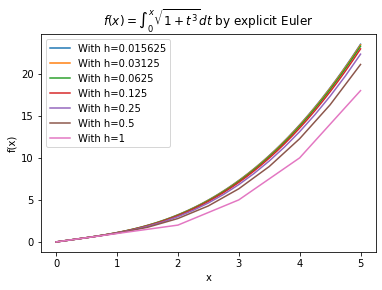

In [103]:
plt.title('$f(x)=\int_0^x{\sqrt{1+t^3} dt}$ by explicit Euler')
plot_results(results_explicit)

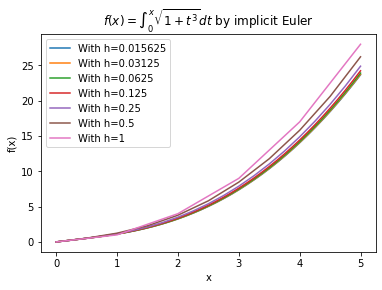

In [104]:
plt.title('$f(x)=\int_0^x{\sqrt{1+t^3} dt}$ by implicit Euler')
plot_results(results_implicit)

### Why we see what we see?